K-Means Clustering of Daily OHLC Bar Data 
https://www.quantstart.com/articles/k-means-clustering-of-daily-ohlc-bar-data

http://intelligenttradingtech.blogspot.com/2010/06/quantitative-candlestick-pattern.html

http://xiuxixiuxi.blogspot.com/2011/05/k-means-clustering-using-r.html

In [150]:
#!pip install https://github.com/matplotlib/mpl_finance/archive/master.zip

  Using cached https://github.com/matplotlib/mpl_finance/archive/master.zip
  Created wheel for mpl-finance: filename=mpl_finance-0.10.1-cp36-none-any.whl size=8423 sha256=893dee303209753fce027be03257c641eee41d35e8a9602ec002320c96dbb740
  Stored in directory: /tmp/pip-ephem-wheel-cache-jjyz3aof/wheels/8f/bf/8a/6c858b2a3be945c7b2d658fbf6ab797b451d686cbee8aa2679
Successfully built mpl-finance


In [5]:
# ohlc_clustering.py

import copy
import datetime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_finance as mf
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from matplotlib.dates import (
    DateFormatter, WeekdayLocator, DayLocator, MONDAY
)
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from sklearn.cluster import KMeans

ImportError: cannot import name 'MapWrapper'

In [2]:
# ohlc_clustering.py

import copy
import datetime

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_finance
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from matplotlib.dates import (
    DateFormatter, WeekdayLocator, DayLocator, MONDAY
)
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from sklearn.cluster import KMeans

/anaconda3/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


ModuleNotFoundError: No module named 'numpy.testing.nosetester'

In [0]:
def get_open_normalised_prices(symbol, start, end):
    """
    Obtains a pandas DataFrame containing open normalised prices
    for high, low and close for a particular equities symbol
    from Yahoo Finance. That is, it creates High/Open, Low/Open
    and Close/Open columns.
    """
    df = web.DataReader(symbol, "yahoo", start, end)
    df["H/O"] = df["High"]/df["Open"]
    df["L/O"] = df["Low"]/df["Open"]
    df["C/O"] = df["Close"]/df["Open"]
    df.drop(
        [
            "Open", "High", "Low",
            "Close", "Volume", "Adj Close"
        ],
        axis=1, inplace=True
    )
    return df

In [0]:
def make_open_normalised_prices(df, start, end):
    df["H/O"] = df["High"]/df["Open"]
    df["L/O"] = df["Low"]/df["Open"]
    df["C/O"] = df["Close"]/df["Open"]
    df.drop(
        [
            "Open", "High", "Low",
            "Close", "Volume", "Adj Close"
        ],
        axis=1, inplace=True
    )
    return df

In [0]:
def plot_candlesticks(data, since):
    """
    Plot a candlestick chart of the prices,
    appropriately formatted for dates
    """
    # Copy and reset the index of the dataframe
    # to only use a subset of the data for plotting
    df = copy.deepcopy(data)
    df = df[df['Date'] >= since]
    df.reset_index(inplace=True)
    df['date_fmt'] = df['Date'].apply(
        lambda date: mdates.date2num(date.to_pydatetime())
    )

    # Set the axis formatting correctly for dates
    # with Mondays highlighted as a "major" tick
    mondays = WeekdayLocator(MONDAY)
    alldays = DayLocator()
    weekFormatter = DateFormatter('%b %d')
    fig, ax = plt.subplots(figsize=(16,4))
    fig.subplots_adjust(bottom=0.2)
    ax.xaxis.set_major_locator(mondays)
    ax.xaxis.set_minor_locator(alldays)
    ax.xaxis.set_major_formatter(weekFormatter)

    # Plot the candlestick OHLC chart using black for
    # up days and red for down days

    colnames = ['date_fmt', 'Open', 'High', 'Low', 'Close']
    df = df[colnames]

    for col in colnames[1:]:
      df[col] = pd.to_numeric(df[col])

    dfl = df.values 
    csticks = candlestick_ohlc(
        ax, dfl#, width=2
    )

    ax.set_facecolor((1,1,0.9))
    ax.xaxis_date()
    plt.setp(
        plt.gca().get_xticklabels(),
        rotation=45, horizontalalignment='right'
    )
    plt.show()
    

In [0]:
def plot_3d_normalised_candles(data):
    """
    Plot a 3D scatterchart of the open-normalised bars
    highlighting the separate clusters by colour
    """
    fig = plt.figure(figsize=(30, 15))
    ax = Axes3D(fig, elev=21, azim=-136)
    ax.scatter(
        data["H/O"], data["L/O"], data["C/O"],
        c=labels.astype(np.float)
    )
    ax.set_xlabel('High/Open')
    ax.set_ylabel('Low/Open')
    ax.set_zlabel('Close/Open')
    plt.show()

In [0]:
def plot_cluster_ordered_candles(data):
    """
    Plot a candlestick chart ordered by cluster membership
    with the dotted blue line representing each cluster
    boundary.
    """
    # Set the format for the axis to account for dates
    # correctly, particularly Monday as a major tick
    mondays = WeekdayLocator(MONDAY)
    alldays = DayLocator()
    weekFormatter = DateFormatter("")
    fig, ax = plt.subplots(figsize=(40,15))
    ax.xaxis.set_major_locator(mondays)
    ax.xaxis.set_minor_locator(alldays)
    ax.xaxis.set_major_formatter(weekFormatter)

    # Sort the data by the cluster values and obtain
    # a separate DataFrame listing the index values at
    # which the cluster boundaries change
    df = copy.deepcopy(data)
    df.sort_values(by="Cluster", inplace=True)
    df.reset_index(inplace=True)
    df["clust_index"] = df.index
    df["clust_change"] = df["Cluster"].diff()
    change_indices = df[df["clust_change"] != 0]

    # Plot the OHLC chart with cluster-ordered "candles"
    csticks = candlestick_ohlc(
        ax, df[
            ["clust_index", 'Open', 'High', 'Low', 'Close']
        ].values, width=0.6,
        colorup='#000000', colordown='#ff0000'
    )
    ax.set_facecolor((1,1,0.9))

    # Add each of the cluster boundaries as a blue dotted line
    for row in change_indices.iterrows():
        plt.axvline(
            row[1]["clust_index"],
            linestyle="dashed", c="blue"
        )
    plt.xlim(0, len(df))
    plt.setp(
        plt.gca().get_xticklabels(),
        rotation=45, horizontalalignment='right'
    )
    plt.show()

In [0]:
def create_follow_cluster_matrix(data):
    """
    Creates a k x k matrix, where k is the number of clusters
    that shows when cluster j follows cluster i.
    """
    data["ClusterTomorrow"] = data["Cluster"].shift(-1)
    data.dropna(inplace=True)
    data["ClusterTomorrow"] = data["ClusterTomorrow"].apply(int)
    data["ClusterMatrix"] = list(zip(data["Cluster"], data["ClusterTomorrow"]))
    cmvc = data["ClusterMatrix"].value_counts()
    clust_mat = np.zeros( (k, k) )
    for row in cmvc.iteritems():
        clust_mat[row[0]] = row[1]*100.0/len(data)
    print("Cluster Follow-on Matrix:")
    print(clust_mat)

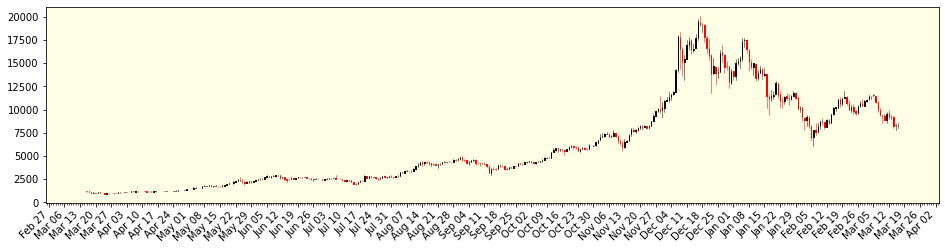

In [183]:
symbol = 'BTC-USD'
# Obtain pricing data from Yahoo Finance
start = datetime.datetime(2017, 3, 16)
end = datetime.datetime(2018, 3, 15)
df = web.DataReader(symbol, 'yahoo', start, end)
df["Date"] = df.index

colnames = ['Date', 'Open', 'High', 'Low', 'Close']
df = df[colnames]
ohlc_df=pd.DataFrame.from_records(df, columns=colnames)

# Plot last year of price "candles"
plot_candlesticks(ohlc_df, datetime.datetime(2017, 3, 16))

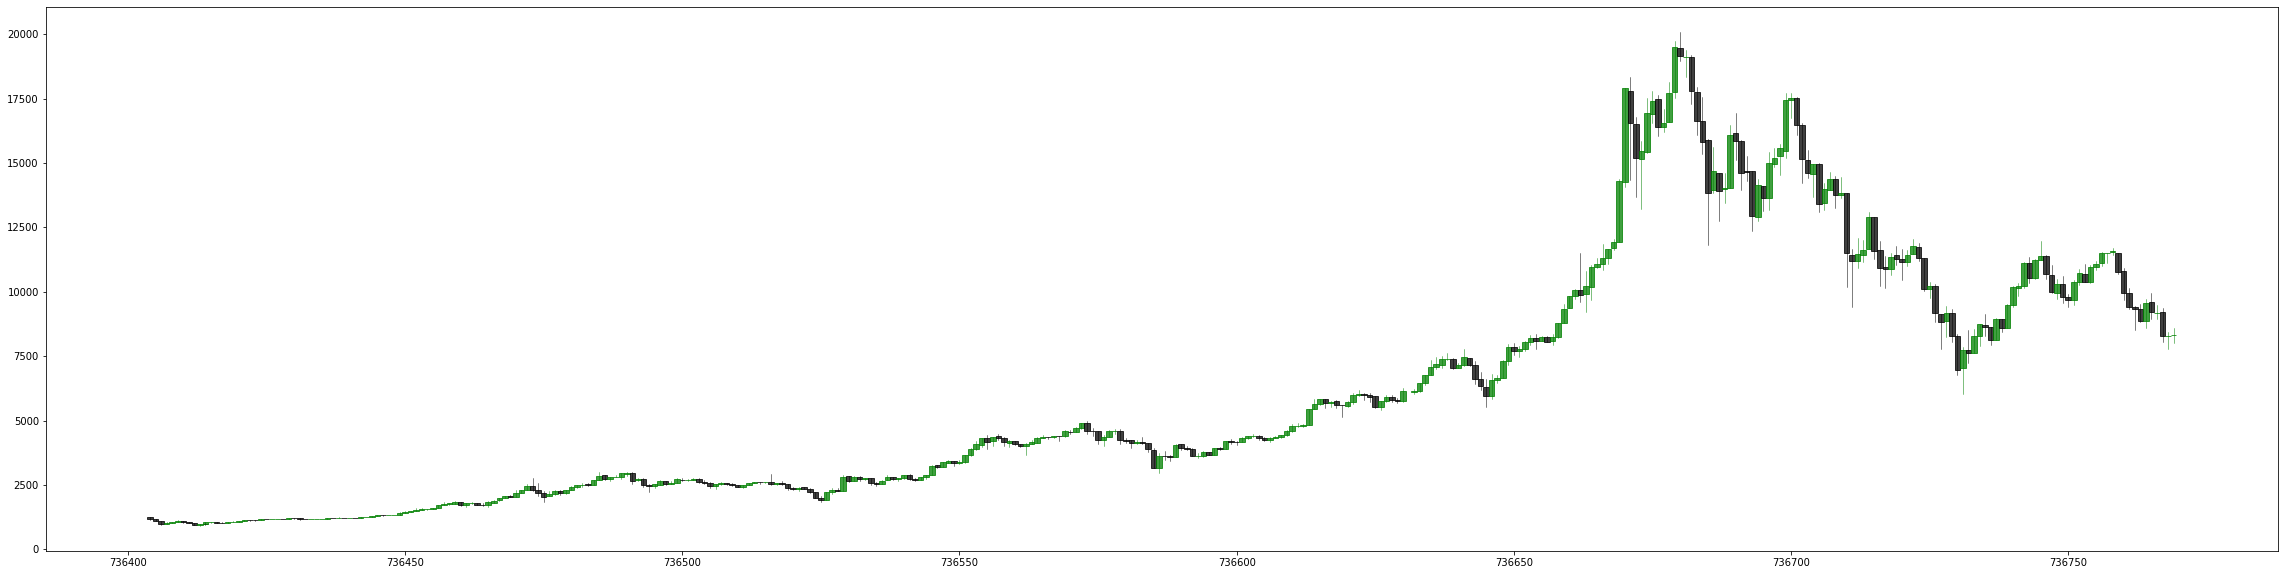

In [184]:
df = ohlc_df
df.reset_index(inplace=True)
df['date_fmt'] = df['Date'].apply(
        lambda date: mdates.date2num(date.to_pydatetime())
)

colnames = ['date_fmt', 'Open', 'High', 'Low', 'Close']
df = df[colnames]

df.head()
dfl = df.values.tolist()
    
    
#Making plot area
fig = plt.figure(figsize=(40,10))
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=6, colspan=1)

#Making candlestick plot
candlestick_ohlc(ax1,dfl,width=1, colorup='g', colordown='k',alpha=0.75)
plt.show()

In [185]:
# Carry out K-Means clustering with five clusters on the
# three-dimensional data H/O, L/O and C/O
    
# Carry out K-Means clustering with five clusters on the
# three-dimensional data H/O, L/O and C/O
df_norm = get_open_normalised_prices(symbol, start, end)
df_norm.head()
k = 10
km = KMeans(n_clusters=k, random_state=42)
km.fit(df_norm)
labels = km.labels_
#df_norm["Cluster"] = labels
df["Cluster"] = labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


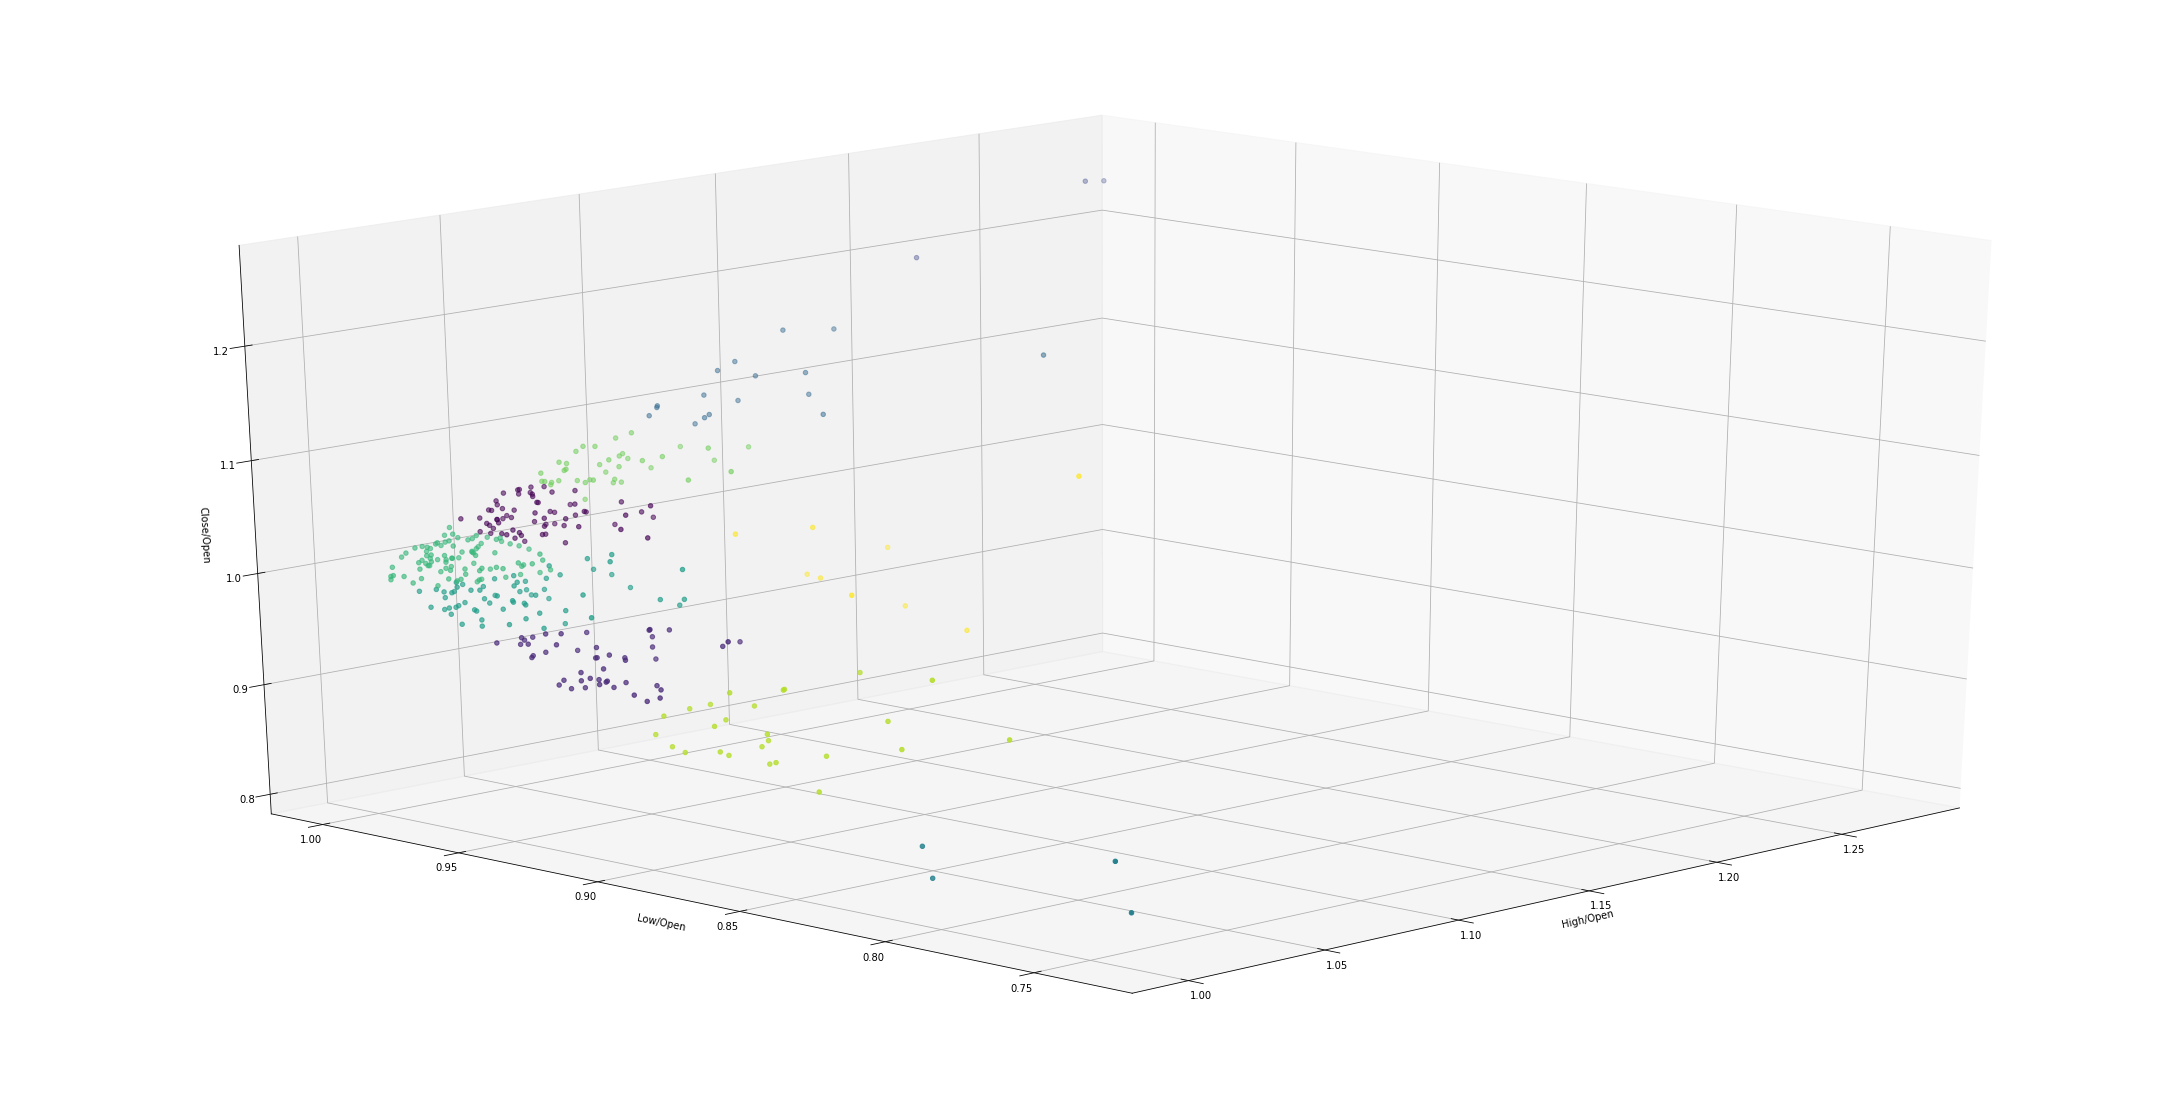

In [186]:
# # Plot the 3D normalised candles using H/O, L/O, C/O
plot_3d_normalised_candles(df_norm)

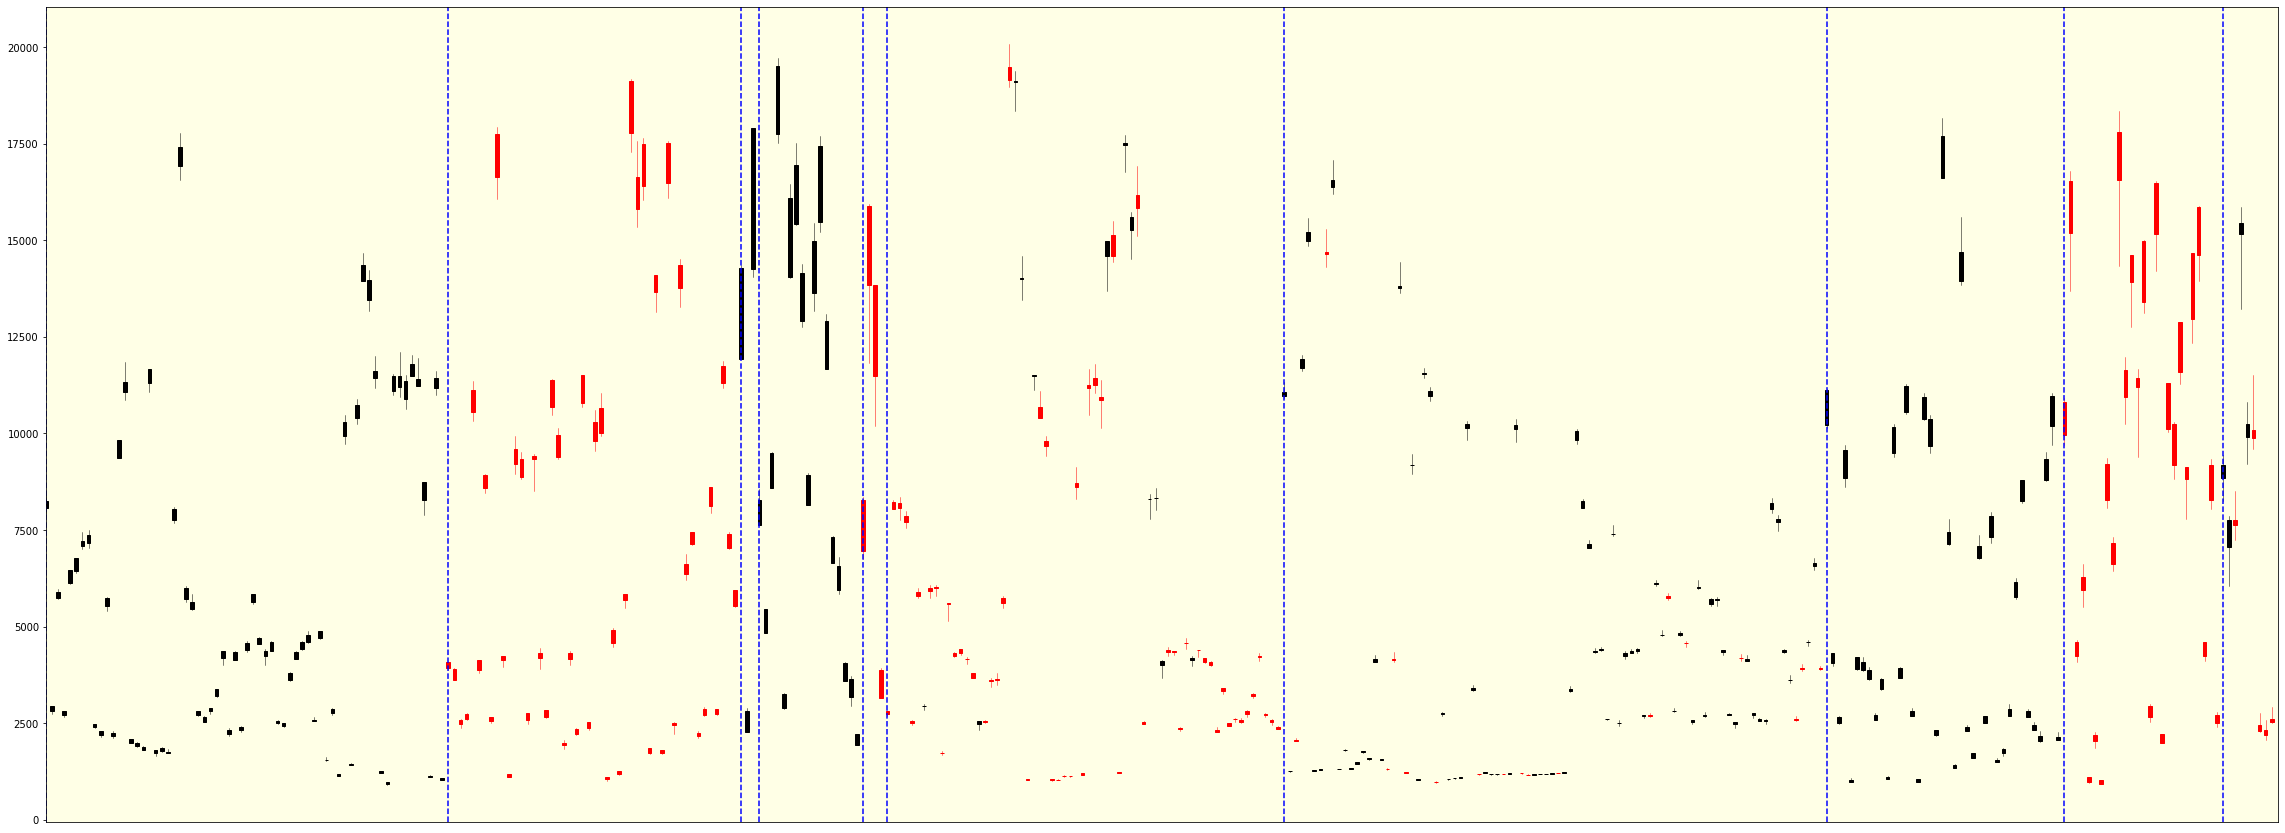

In [187]:
# # Plot the full OHLC candles re-ordered
# # into their respective clusters
plot_cluster_ordered_candles(df)

In [190]:
# # Create and output the cluster follow-on matrix
F = create_follow_cluster_matrix(df)
F

Cluster Follow-on Matrix:
[[4.1322314  2.75482094 0.         0.55096419 0.         3.03030303
  6.33608815 1.37741047 0.         0.        ]
 [1.92837466 1.65289256 0.         1.10192837 0.55096419 2.47933884
  2.75482094 0.82644628 1.92837466 0.        ]
 [0.         0.27548209 0.27548209 0.         0.         0.
  0.         0.         0.27548209 0.        ]
 [1.10192837 0.82644628 0.         0.         0.         1.37741047
  0.55096419 0.55096419 0.27548209 0.        ]
 [0.         0.         0.         0.27548209 0.         0.
  0.         0.27548209 0.27548209 0.27548209]
 [3.58126722 2.20385675 0.27548209 0.82644628 0.         3.85674931
  3.85674931 1.37741047 1.37741047 0.        ]
 [3.58126722 2.20385675 0.27548209 0.55096419 0.27548209 4.68319559
  7.43801653 3.58126722 1.37741047 0.55096419]
 [2.75482094 1.92837466 0.         0.27548209 0.         0.82644628
  2.47933884 1.92837466 0.27548209 0.27548209]
 [1.10192837 1.10192837 0.         0.55096419 0.27548209 1.10192837
  